This is an exploratory analysis of the Instacart dataset
  
[Data dictionary](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b)

In [48]:
import pandas as pd
import os
%matplotlib inline

In [28]:
# Read all the files

data_folder = "datasets_/instacart_2017_05_01/"

aisles = pd.read_csv(os.path.join(data_folder, "aisles.csv"))
departments = pd.read_csv(os.path.join(data_folder, "departments.csv"))
order_prod_train = pd.read_csv(os.path.join(data_folder, "order_products__train.csv"))

products = pd.read_csv(os.path.join(data_folder, "products.csv"))

# Sample from the big files for now
order_prod_prior_samp = pd.read_csv(os.path.join(data_folder, "order_products__prior.csv"),nrows=1000)
orders = pd.read_csv(os.path.join(data_folder, "orders.csv"),nrows=1000)



### Departments file describes 21 departments - broad product categories
  
No data is missing

In [29]:
departments.head(10)

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [30]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
department_id    21 non-null int64
department       21 non-null object
dtypes: int64(1), object(1)
memory usage: 416.0+ bytes


### Aisles file describes 134 subcategories within departments
  
No data is missing

In [31]:
aisles.head(10)

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation
5,6,other
6,7,packaged meat
7,8,bakery desserts
8,9,pasta sauce
9,10,kitchen supplies


In [32]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
aisle_id    134 non-null int64
aisle       134 non-null object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


### Products file maps each product id to a name, aisle and department
  
There are 49688 unique products  
No data is missing

In [33]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
product_id       49688 non-null int64
product_name     49688 non-null object
aisle_id         49688 non-null int64
department_id    49688 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [34]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [35]:
products.product_id.nunique()

49688

Distribution of products in departments and aisles

In [36]:
# Join dept and aisle descriptions
products = pd.merge(products, aisles, "left")
products = pd.merge(products, departments, "left")

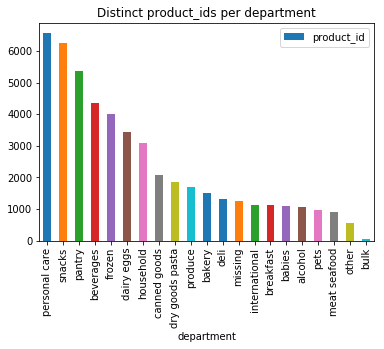

In [53]:
dept_counts = products.groupby("department")["product_id"].nunique()\
.reset_index().sort_values("product_id",ascending=False)

dept_counts.head()

dept_counts.plot.bar(x="department", y="product_id", title="Distinct product_ids per department")

We can see that most departments contain over a 1000 unique products. The only department with a very low count of unique products is "bulk".  
There is also a sizeable number of products where the deparment is set to "missing".

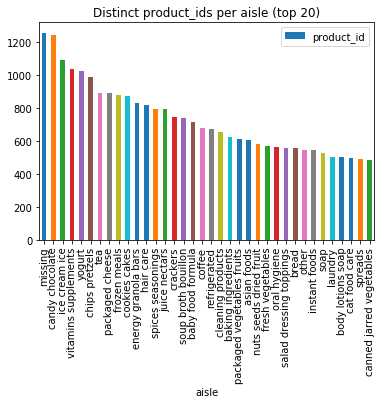

In [60]:
aisle_counts = products.groupby("aisle")["product_id"].nunique()\
.reset_index().sort_values("product_id",ascending=False)

aisle_counts.loc[:20].plot.bar(x="aisle", y="product_id", title="Distinct product_ids per aisle (top 20)")

Findings:  
1) Aisle set to "missing" is the biggest category for more than 1200 products, followed by "candy chocolate" and "ice cream ice" aisles.  
2) Most aisles contain hundreds of distinct products

### Order_products_train
Lists the products ordered by customers with a label if each product was reordered or not 
- order_id: foreign key
- product_id: foreign key
- add_to_cart_order: order in which each product was added to cart
- reordered: 1 if this product has been ordered by this user in the past, 0 otherwise

In [10]:
order_prod_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
order_id             1384617 non-null int64
product_id           1384617 non-null int64
add_to_cart_order    1384617 non-null int64
reordered            1384617 non-null int64
dtypes: int64(4)
memory usage: 42.3 MB


In [11]:
order_prod_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## Orders (big file)

3M past orders

In [62]:
order_prod_prior = pd.read_csv(os.path.join(data_folder, "order_products__prior.csv"))


In [72]:
# Get the distribution of the number of past orders per customer

# Distribution of basket sizes (product count in an order)
products_per_order = order_prod_prior.groupby("order_id")["product_id"].count()\
.reset_index().rename(index=str, columns={"product_id": "product_id_cnt"})


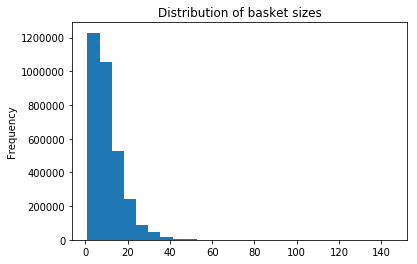

In [73]:
# products_per_order.reset_index(inplace=True)
products_per_order["product_id_cnt"].plot.hist(title="Distribution of basket sizes", bins=25)

In [79]:
# Share of orders with 1 or 2 products
basket_size_share = products_per_order.groupby("product_id_cnt")["order_id"].count()\
.reset_index().rename(index=str, columns={"order_id": "order_id_cnt"})

basket_size_share["share"]=  basket_size_share["order_id_cnt"]/sum(basket_size_share["order_id_cnt"])

basket_size_share[basket_size_share.product_id_cnt.isin([1,2,3])]

,product_id_cnt,order_id_cnt,share
0,1,156748,0.048757
1,2,186993,0.058165
2,3,207027,0.064397


Findings:  
1) The histogram of basket sizes shows that most orders contain less than 20 products  
2) About 5% of all orders contain only a single product, another 6% -just two products
  
This means that unless there is a strong association between ordering of some items together (e.g. shampoo and conditioner, cereals and milk), the usefulness of items in the same order with the product we're trying to predict will be limited. 